<a href="https://colab.research.google.com/github/Jade-P/MLGroupProject/blob/Happy--Sohyun/Preprocessing_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment & path Setup 

In [ ]:
# Download dataset
!wget https://raw.githubusercontent.com/Jade-P/MLGroupProject/main/archive.zip

--2022-12-05 03:49:17--  https://raw.githubusercontent.com/Jade-P/MLGroupProject/main/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62587032 (60M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]  59.69M   260MB/s    in 0.2s    

2022-12-05 03:49:20 (260 MB/s) - ‘archive.zip’ saved [62587032/62587032]



In [ ]:
!unzip -qq archive.zip

#Load Data

In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
RANDOM_SEED = 123

In [ ]:
TRAIN_DIR = ('Training/Training/')
TEST_DIR = ('Testing/Testing/')

In [ ]:
emotions = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

In [ ]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(emotions)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255 # NORMALIZES PIXELS 
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
IMG_SIZE= (48, 48)

In [ ]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


28273 images loaded from Training/Training/ directory.


In [ ]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [ ]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


7067 images loaded from Testing/Testing/ directory.


In [ ]:
X_train.shape

(28273, 48, 48, 3)

#Data preprocessing

##Removing Duplicates

Remove duplicates of image to prevent overfitting.

resource: https://mizykk.tistory.com/55

In [ ]:
import pandas as pd

In [ ]:
import cv2  
from skimage.metrics import structural_similarity

image_list = []

path = TRAIN_DIR + '/Happy'

for f in os.listdir(path):
  image_list.append(f)

img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))

# Find Same Photos
img_data = pd.DataFrame({'filename':image_list, 'size':img_size})

print('number of images :', len(img_data))

number of images : 7215


In [ ]:
img_data

,filename,size
0,Happy-5010.jpg,1807
1,Happy-683.jpg,1531
2,Happy-143.jpg,1725
3,Happy-1930.jpg,1388
4,Happy-662.jpg,1533
...,...,...
7210,Happy-4355.jpg,1656
7211,Happy-4270.jpg,1185
7212,Happy-3923.jpg,1770
7213,Happy-239.jpg,1538


In [ ]:
# Photo Value Counts
filename_cnts = pd.DataFrame({'filename':img_data['filename'].value_counts().index, 'fn_counts':img_data['filename'].value_counts().values})   
imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   

img_data = pd.merge(img_data, filename_cnts, how = 'left', on = 'filename')
img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')

img_data.sample(2)

,filename,size,fn_counts,size_counts
874,Happy-7131.jpg,1610,1,18
6081,Happy-4561.jpg,1530,1,16


In [ ]:
SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

###Use structural similarity to compare similarity of images

In [ ]:
def CompareImage(imageA, imageB):

    # Grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Check Image structure
    if len(grayA)==len(grayB):
        (score, diff) = structural_similarity(grayA, grayB, full=True)

    return score

In [ ]:
delete = dict()

In [ ]:
for i in range(len(SimilarSizeData)):

    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    for j in range(len(temp) - 1):
      filenameA = temp['filename'][j]
      compared = False

      for key in delete:
        if (filenameA in delete[key]):
          compared = True
          break
      
      if compared:
        continue

      for k in range(j+1, len(temp)):
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        
        if (score == 1 or score > 0.6):
          if filenameA not in delete:
            delete[filenameA] = [filenameB]
          else:
            delete[filenameA].append(filenameB)
          if (score < 1):
            print(filenameA + ", " + filenameB)
            print("score: " + str(score))
          

Happy-2461.jpg, Happy-6680.jpg
score: 0.7168389603349193


### See if similar images are similar enough to be removed

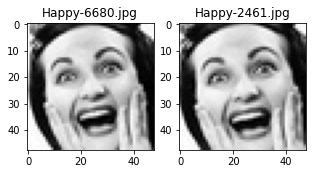

In [ ]:
plt.figure(0, figsize=(5,3))
ax = plt.subplot(1,2,1)
ax.set_title('Happy-6680.jpg')
img1 = cv2.imread(path+"/"+ 'Happy-6680.jpg')
plt.imshow(img1,cmap="gray")

ax = plt.subplot(1,2,2)
ax.set_title('Happy-2461.jpg')
img2 = cv2.imread(path+"/"+ 'Happy-2461.jpg')
plt.imshow(img2,cmap="gray")

In [ ]:
total = [len(value) for key, value in delete.items()]
print(str(sum(total)) + " duplicates found")

129 duplicates found


###Plotting some duplicates to confirm they are the same

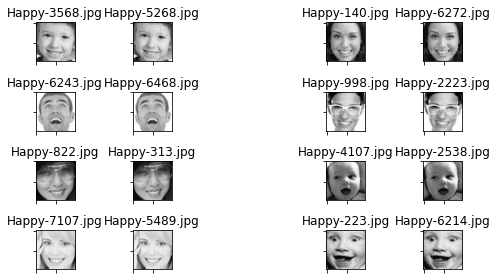

In [ ]:
plt.figure(0, figsize=(8,4))
cpt = 0

n = 8

for key in delete:
  if (n == 0):
    break

  cpt += 1
  ax = plt.subplot(4,6,cpt)
  ax.set_title(key)
  img = cv2.imread(path+"/"+ key)
  plt.tick_params(labelleft=False,labelbottom=False)
  plt.imshow(img,cmap="gray")

  for file in delete[key]:
    cpt += 1
    ax = plt.subplot(4,6,cpt)
    ax.set_title(file)

    img = cv2.imread(path+"/"+ file)
    plt.tick_params(labelleft=False,labelbottom=False)
    plt.imshow(img,cmap="gray")
    pass
  
  if (cpt % 3 != 0):
    cpt +=1
  n -= 1

plt.tight_layout()
plt.show()

In [ ]:
orig_list = image_list

print("original image number: " + str(len(orig_list)))

original image number: 7215


In [ ]:
for key in delete:
  for val in delete[key]:
    image_list.remove(val)

print("updated images number: " + str(len(image_list)))

updated images number: 7086


###Remove images

In [ ]:
for key in delete:
  print("Removing duplicates of " + key)
  for val in delete[key]:
    print(val + " removed")
    os.remove(TRAIN_DIR + "Happy/" + val)

###Removing Duplicates (Repeat for other classes)

In [ ]:
import cv2  
from skimage.metrics import structural_similarity

def getImgData(path):

  image_list = []

  for f in os.listdir(path):
    image_list.append(f)

  img_size = list(map(lambda x: os.path.getsize(path + '/' + x), image_list))

  img_data = pd.DataFrame({'filename':image_list, 'size':img_size})

  print('number of images :', len(img_data))
  return img_data

In [ ]:
def getDuplicates(img_data):
  # Photo Value Counts
  imgsize_cnts = pd.DataFrame({'size':img_data['size'].value_counts().index, 'size_counts':img_data['size'].value_counts().values})   
  img_data = pd.merge(img_data, imgsize_cnts, how = 'left', on = 'size')
  SimilarSizeData = imgsize_cnts[imgsize_cnts['size_counts'] > 1]

  delete = dict()

  for i in range(len(SimilarSizeData)):
    temp = img_data[img_data['size']==SimilarSizeData['size'][i]].reset_index(drop = True).sort_values(['filename'])

    for j in range(len(temp) - 1):
      filenameA = temp['filename'][j]
      compared = False

      for key in delete:
        if (filenameA in delete[key]):
          compared = True
          break
      
      if compared:
        continue

      for k in range(j+1, len(temp)):
        filenameB = temp['filename'][k]
        
        imageA = cv2.imread(path+'/'+filenameA)
        imageB = cv2.imread(path+'/'+filenameB)

        score = CompareImage(imageA, imageB)
        
        if (score == 1 or score > 0.6):
          if filenameA not in delete:
            delete[filenameA] = [filenameB]
          else:
            delete[filenameA].append(filenameB)
          if (score < 1):
            print(filenameA + ", " + filenameB)
            print("score: " + str(score))
          
    total = [len(value) for key, value in delete.items()]
    print(str(sum(total)) + " duplicates found")

    return delete

In [ ]:
def plotDuplicates(path, delete):

    plt.figure(0, figsize=(8,4))
    cpt = 0

    n = 8
    
    for key in delete:
      if (n == 0):
        break

      cpt += 1
      ax = plt.subplot(4,6,cpt)
      ax.set_title(key)
      img = cv2.imread(path+"/"+ key)
      plt.tick_params(labelleft=False,labelbottom=False)
      plt.imshow(img,cmap="gray")

      for file in delete[key]:
        cpt += 1
        ax = plt.subplot(4,6,cpt)
        ax.set_title(file)

        img = cv2.imread(path+"/"+ file)
        plt.tick_params(labelleft=False,labelbottom=False)
        plt.imshow(img,cmap="gray")
        pass
      
      while (cpt % 4 != 0):
        cpt +=1
      n -= 1

    plt.tight_layout()
    plt.show()

In [ ]:
def removeDuplicates(path, delete, image_list):
    orig_list = image_list
    print("original image number: " + str(len(orig_list)))

    for key in delete:
      for val in delete[key]:
        image_list.remove(val)
    print("updated images number: " + str(len(image_list)))

    remove_cnt = 0

    for key in delete:
      for val in delete[key]:
        os.remove(path + "/" + val)
        remove_cnt +=1

    print(str(remove_cnt) + " number of duplicates removed")

Finding for duplicates in class Angry...
number of images : 3995
Angry-1917.jpg, Angry-1718.jpg
score: 0.8265641046829441
Angry-1917.jpg, Angry-2085.jpg
score: 0.8265641046829441
Angry-1917.jpg, Angry-18.jpg
score: 0.8265641046829441
4 duplicates found


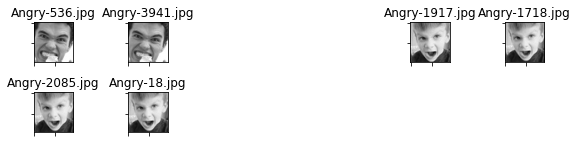

original image number: 3995
updated images number: 3991
4 number of duplicates removed


Finding for duplicates in class Fear...
number of images : 4097
4 duplicates found


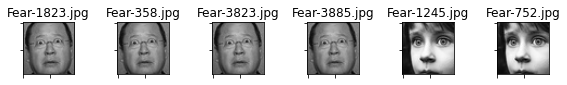

original image number: 4097
updated images number: 4093
4 number of duplicates removed


Finding for duplicates in class Happy...
number of images : 7086
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 7086
updated images number: 7086
0 number of duplicates removed


Finding for duplicates in class Neutral...
number of images : 4965
0 duplicates found


<Figure size 576x288 with 0 Axes>

original image number: 4965
updated images number: 4965
0 number of duplicates removed


Finding for duplicates in class Sad...
number of images : 4830
2 duplicates found


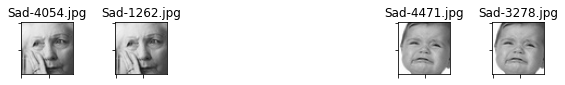

original image number: 4830
updated images number: 4828
2 number of duplicates removed


Finding for duplicates in class Suprise...
number of images : 3171
6 duplicates found


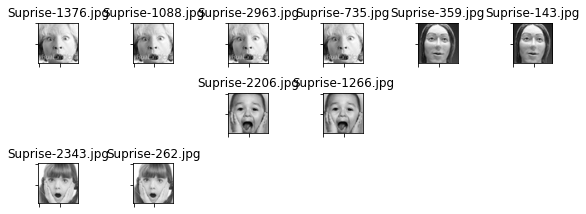

original image number: 3171
updated images number: 3165
6 number of duplicates removed




In [ ]:
for emotion in emotions:
  print("Finding for duplicates in class " + emotion + "...")

  path = TRAIN_DIR + emotion
  image_list = []

  for f in os.listdir(path):
    image_list.append(f)

  img_data = getImgData(path)
  delete_list = getDuplicates(img_data)
  plotDuplicates(path, delete_list)
  removeDuplicates(path, delete_list, image_list)

  print("\n")

##Removing outliers (faulty inputs)

Remove image that doesn't look like a face, or includes more than one face. Outliers were found manually.

In [ ]:
Happy_outliers = [1414,2541,4488,5326,1091,1817,2039,2226,2250,2819,3964,4123,6270,6441,6627]

In [ ]:
path = TRAIN_DIR + "Happy"

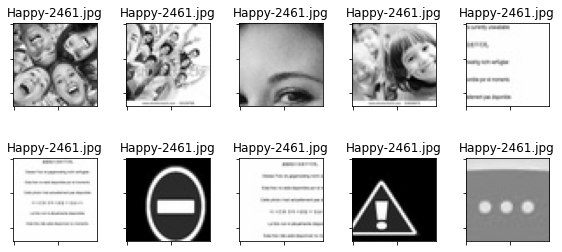

In [ ]:
plt.figure(0, figsize=(8,4))
cpt = 0

n = 10

for outlier in Happy_outliers:
  if (n == 0):
    break

  cpt += 1
  ax = plt.subplot(2,5,cpt)
  ax.set_title(key)
  img = cv2.imread(path+"/"+ "Happy-" + str(outlier) + ".jpg")
  plt.tick_params(labelleft=False,labelbottom=False)
  plt.imshow(img,cmap="gray")

  n -= 1

plt.tight_layout()
plt.show()

In [ ]:
for outlier in Happy_outliers:
  os.remove(TRAIN_DIR + "Happy/Happy-" + str(outlier) + ".jpg")

In [ ]:
emotions

['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

###Repeat for other classes

In [ ]:
outliers = {'Angry': [786, 930, 1078, 1596, 1730, 1835, 1866, 2185, 2822, 2903, 3091, 3384, 3714, 3975], 
            'Fear':[768, 562], 
            'Neutral':[1058, 2062, 2156, 2657, 2997, 3392, 363, 3767, 3977, 4186, 4352, 4473, 4859], 
            'Sad':[1721, 1891, 1966, 4001],
            'Suprise':[80, 128, 211, 213, 233, 259, 300, 309, 312, 335, 353, 596, 611, 665, 758, 1288, 1499, 2055, 2214, 2276]}

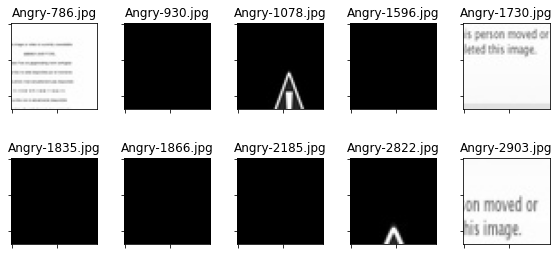

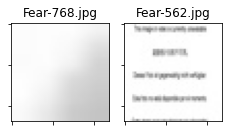

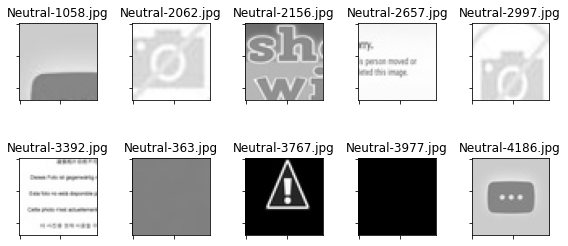

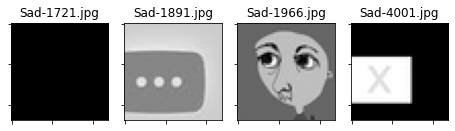

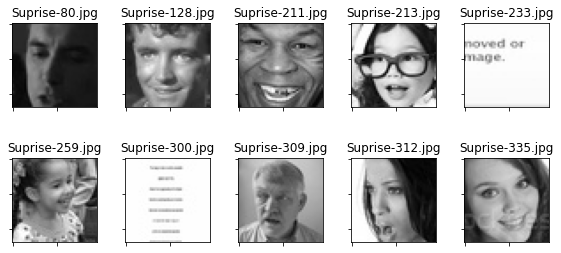

In [ ]:
for emotion in outliers:
  path = TRAIN_DIR + emotion

  plt.figure(0, figsize=(8,4))
  cpt = 0

  n = 10

  for outlier in outliers[emotion]:
    if (n == 0):
      break

    cpt += 1
    ax = plt.subplot(2,5,cpt)
    img_name = emotion + "-" + str(outlier) + ".jpg"
    ax.set_title(img_name)
    img = cv2.imread(path+"/"+ img_name)
    plt.tick_params(labelleft=False,labelbottom=False)
    plt.imshow(img,cmap="gray")

    n -= 1

  plt.tight_layout()
  plt.show()

  #remove outlier
  for outlier in outliers[emotion]:
    os.remove(path + "/" + emotion + "-" + str(outlier) + ".jpg")

##Image Augmentation (Oversampling)

In [ ]:
_, train_count = np.unique(y_train,return_counts=True)
_, test_count = np.unique(y_test,return_counts=True)

df = pd.DataFrame(data = (train_count,test_count))
df = df.T
df['Name'] = emotions
data = df.rename(columns={0: "train", 1: "test", "Name" : "emotion"})

In [ ]:
Happy_train_num = data[data['emotion']=='Happy']['train'].reset_index(drop=True)[0]

In [ ]:
data['oversampling'] = (Happy_train_num - data['train']) // 10 * 8

In [ ]:
data

,train,test,emotion,oversampling
0,3995,958,Angry,2576
1,4097,1024,Fear,2488
2,7215,1774,Happy,0
3,4965,1233,Neutral,1800
4,4830,1247,Sad,1904
5,3171,831,Suprise,3232


In [ ]:
imbalanced = ['Angry', 'Fear', 'Neutral', 'Sad', 'Suprise']

In [ ]:
import imutils

def augmentImage(img):
  flipped = tf.image.flip_left_right(img)
  b_changed = tf.image.random_brightness(flipped, 0.2)
  c_changed = tf.image.random_contrast(b_changed, 0.7, 0.9)
  rotated = imutils.rotate(c_changed.numpy(), np.random.randint(15))
  cropped = tf.image.crop_to_bounding_box(rotated, 6, 6, 36, 36)
  final = tf.image.resize(cropped / 255, [48, 48])
  return final

In [ ]:
def generateImages(dataPath, sampled_choices):
  for file in sampled_choices:
    image = cv2.imread(dataPath+'/'+file)
    new_image = augmentImage(image)
    tf.keras.preprocessing.image.save_img(dataPath+'/'+file[:-4] + '-aug.jpg', new_image)

In [ ]:
import cv2  

for emotion in imbalanced:

  image_list = []
  data_path = TRAIN_DIR + '/' + emotion

  for f in os.listdir(data_path):
    image_list.append(f)

  sampled_choices = np.random.choice(image_list, data[data['emotion']==emotion]['oversampling'].reset_index(drop=True)[0])
  generateImages(data_path, sampled_choices)

Plot example of image augmentation

In [ ]:
for f in os.listdir(path):
  if (f[-7:-4] == 'aug'):
    example_img = f
    break

example_img_origin = example_img[:-8] + '.jpg'

Original image

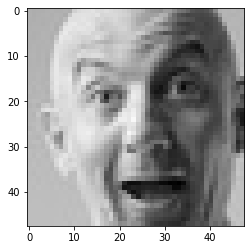

In [ ]:
img = cv2.imread(path+"/"+ example_img_origin)
plt.imshow(img)

Augmented image

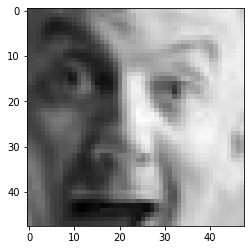

In [ ]:
img = cv2.imread(path+"/"+ example_img)
plt.imshow(img)

###Zip the preprocessed file

In [ ]:
!zip -r 'preprocessed.zip' 'Testing' 'Training'

#Sources

https://www.kaggle.com/code/basel99/facial-recognition

https://mizykk.tistory.com/55